## Intro
Mask-RCNN работает хорошо, но относительно медленно (~100 ms/image на GPU в Colab), в дополнение к этому используемые данные - это сверхразреженные матрицы, поэтому неэффективно работать с ними как с обычными изображениями. 

Sparse Convolutinal Networks предоставляют подход к свёрткам на разреженных данных, и этот ноутбук демонстрирует преимущество в скорости этого метода

## Prepare environment

In [1]:
!git clone https://github.com/facebookresearch/SparseConvNet.git
%cd SparseConvNet/

Cloning into 'SparseConvNet'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1866 (delta 8), reused 4 (delta 2), pack-reused 1841
Receiving objects: 100% (1866/1866), 900.88 KiB | 983.00 KiB/s, done.
Resolving deltas: 100% (1326/1326), done.
/content/SparseConvNet


In [2]:
!python setup.py develop -q

Streaming output truncated to the last 5000 lines.
                 from /usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include/torch/data/dataloader/base.h:3,
                 from /usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include/torch/data/dataloader/stateful.h:3,
                 from /usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include/torch/data/dataloader.h:3,
                 from /usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include/torch/data.h:3,
                 from /usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include/torch/all.h:4,
                 from /usr/local/lib/python3.6/dist-packages/torch/include/torch/extension.h:4,
                 from sparseconvnet/SCN/sparseconvnet_cuda.cpp:14:
/usr/local/lib/python3.6/dist-packages/torch/include/ATen/core/TensorBody.h:262:30: note: declared here
   DeprecatedTypeProperties & type() const {
                     

In [0]:
import sparseconvnet as scn
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [0]:
use_cuda = torch.cuda.is_available() and scn.SCN.is_cuda_build()
device = 'cuda:0' if use_cuda else 'cpu'
device = 'cpu'

In [5]:
!git clone https://github.com/82492749123082/farich-pics.git -b dev #clone dev-branch
%cd farich-pics
!pip install gdown -q #install package

Cloning into 'farich-pics'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 457 (delta 45), reused 136 (delta 18), pack-reused 289
Receiving objects: 100% (457/457), 8.84 MiB | 6.00 MiB/s, done.
Resolving deltas: 100% (178/178), done.
/content/SparseConvNet/farich-pics


In [6]:
# url_dataset, dataset_path = "1_Fm3mRAlioL3sCO0Gm9elb7fVa-KugkO", "dataset.pkl" #one circle dataset
url_dataset, dataset_path = "1V1r0P1QMRpoYhI1tKcGnWXEjdutjXcIV", "dataset.pkl"
!gdown --id $url_dataset -O $dataset_path

Downloading...
From: https://drive.google.com/uc?id=1V1r0P1QMRpoYhI1tKcGnWXEjdutjXcIV
To: /content/SparseConvNet/farich-pics/dataset.pkl
99.2MB [00:01, 93.0MB/s]


In [7]:
%ls

_config.yml  farichlib/  page/      requirements.txt
dataset.pkl  notebooks/  README.md  tests/


## Prepare data



In [0]:
with open(dataset_path, "rb") as f:
    H_res, h_res, mask_res = pickle.load(f)

In [0]:
def prepare_data(H_res):
    H_prep = []
    for H in H_res:
        s = np.random.randint(0, 99)
        rows = np.hstack( (H.row, np.random.randint(99, size=(s) )) )
        cols = np.hstack( (H.col, np.random.randint(99, size=(s) )) )
        label = np.hstack( (H.data, np.ones(s)) )
        target = np.hstack( (np.ones(len(H.col)), np.zeros(s)) )
        H_prep.append( (rows, cols, label, target) )
    return H_prep

In [0]:
H_prep = prepare_data(H_res)

In [11]:
len(H_prep)

10000

In [0]:
from scipy import sparse
hh = H_res[57].copy()

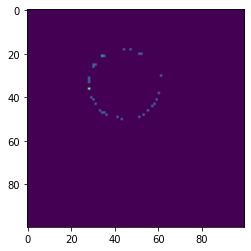

In [13]:
plt.imshow(hh.toarray())

In [0]:
def merge(data):
    for i,H in enumerate( data ):
        row, col, lab, tar = H
        tar = torch.Tensor(tar).long()#.unsqueeze(1) #torch.ones((len(H.data), 1))
        feat = torch.Tensor(lab).unsqueeze(1)
        x = torch.LongTensor( row ).unsqueeze(1)
        y = torch.LongTensor( col ).unsqueeze(1)

        batch = i*(torch.ones_like(x).long())
        loc = torch.cat( (x, y, batch), dim=1 )
        features = torch.cat( (features, feat ) ) if i!=0 else feat
        targets = torch.cat( (targets, tar) ) if i!=0 else tar
        locations = torch.cat( (locations, loc) ) if i!=0 else loc
    # print(locations.shape, features.shape, targets.shape)
    return locations, features, targets

## Net

In [0]:
from sparseconvnet import UNet
#UNet
#reps - #Conv block repetition factor
#nPlanes - #UNet number of features per level

In [0]:
m = 2
model = torch.nn.Sequential(
    scn.InputLayer(2, torch.LongTensor([128, 128])),
    scn.SubmanifoldConvolution(2, 1, m, 3, False),
    scn.UNet(2, 1, [m, 2*m, 3*m, 4*m, 5*m], residual_blocks=False, downsample=[2,2]),
    scn.BatchNormReLU(m),
    scn.OutputLayer(2),
    torch.nn.Softmax(dim=1)
    # torch.nn.Sigmoid()
  )
loss = torch.nn.CrossEntropyLoss() #torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005 )

In [0]:
input, target = merge(H_prep[100:101])[:2], merge(H_prep[100:101])[2]

In [0]:
# %timeit model(input)

In [19]:
pred = model(input)

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [0]:
trainIter = torch.utils.data.DataLoader( H_prep[:9000], collate_fn=merge, shuffle=True, num_workers=16, drop_last=True, batch_size=1000)
testIter  = torch.utils.data.DataLoader( H_prep[9000:], collate_fn=merge, shuffle=True, num_workers=16, drop_last=True, batch_size=1000)

In [0]:
def train(num_epoch):
    for i in range(num_epoch):
        model.train(mode=True)
        train_losses = []
        test_losses = []
        for loc, feat, target in trainIter:
            pred = model([loc, feat])
            # print( pred.shape, loc.shape, feat.shape, target.shape )
            train_loss = loss(pred, target)
            train_losses.append(train_loss.item())
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        res_train = np.mean( np.array(train_losses) )
        model.train(False)
        for loc, feat, target in testIter:
            pred = model([loc, feat])
            test_loss = loss(pred, target)
            test_losses.append(test_loss.item())
        res_test = np.mean( np.array(test_losses) )
        print(f'Epoch {i} | Train loss: {res_train:.4f} | Test loss: {res_test:.4f}')

In [125]:
train(100)

Epoch 0 | Train loss: 0.4175 | Test loss: 0.4361
Epoch 1 | Train loss: 0.4172 | Test loss: 0.4360
Epoch 2 | Train loss: 0.4170 | Test loss: 0.4355
Epoch 3 | Train loss: 0.4167 | Test loss: 0.4349
Epoch 4 | Train loss: 0.4165 | Test loss: 0.4356
Epoch 5 | Train loss: 0.4162 | Test loss: 0.4353
Epoch 6 | Train loss: 0.4161 | Test loss: 0.4345
Epoch 7 | Train loss: 0.4158 | Test loss: 0.4341
Epoch 8 | Train loss: 0.4156 | Test loss: 0.4339
Epoch 9 | Train loss: 0.4153 | Test loss: 0.4339
Epoch 10 | Train loss: 0.4152 | Test loss: 0.4347
Epoch 11 | Train loss: 0.4151 | Test loss: 0.4334
Epoch 12 | Train loss: 0.4146 | Test loss: 0.4343
Epoch 13 | Train loss: 0.4145 | Test loss: 0.4349
Epoch 14 | Train loss: 0.4142 | Test loss: 0.4342
Epoch 15 | Train loss: 0.4140 | Test loss: 0.4339
Epoch 16 | Train loss: 0.4137 | Test loss: 0.4341
Epoch 17 | Train loss: 0.4135 | Test loss: 0.4337
Epoch 18 | Train loss: 0.4132 | Test loss: 0.4337
Epoch 19 | Train loss: 0.4130 | Test loss: 0.4331
Epoch 20 |

In [0]:
input, target = merge(H_prep[9000:10001])[:2], merge(H_prep[9000:10001])[2]

In [100]:
%timeit model(input)

1 loop, best of 3: 443 ms per loop


In [0]:
def plot(i=9000):
    input, target = merge(H_prep[i:i+1])[:2], merge(H_prep[i:i+1])[2]
    pred = model(input).argmax(dim=1)
    row, col, _ = input[0].numpy().T
    val = input[1].numpy().ravel()
    row1, col1, val1 = row[target>0], col[target>0], val[target>0]
    row2, col2, val2 = row[pred>0], col[pred>0], val[pred>0]
    mat0 = sparse.coo_matrix((val, (row, col)), shape=(row.max()+1, col.max()+1))
    mat1 = sparse.coo_matrix((val1, (row1, col1)), shape=(row.max()+1, col.max()+1))
    mat2 = sparse.coo_matrix((val2, (row2, col2)), shape=(row.max()+1, col.max()+1))
    plt.figure(figsize=(20, 20))
    plt.subplot(131)
    plt.imshow(mat0.toarray(), cmap='gnuplot')
    plt.title('Signal+Bkg')
    plt.subplot(132)
    plt.imshow(mat1.toarray(), cmap='gnuplot')
    plt.title('Real signal')
    plt.subplot(133)
    plt.imshow(mat2.toarray(), cmap='gnuplot')
    plt.title('NN signal')
    return

In [0]:
index = 9012

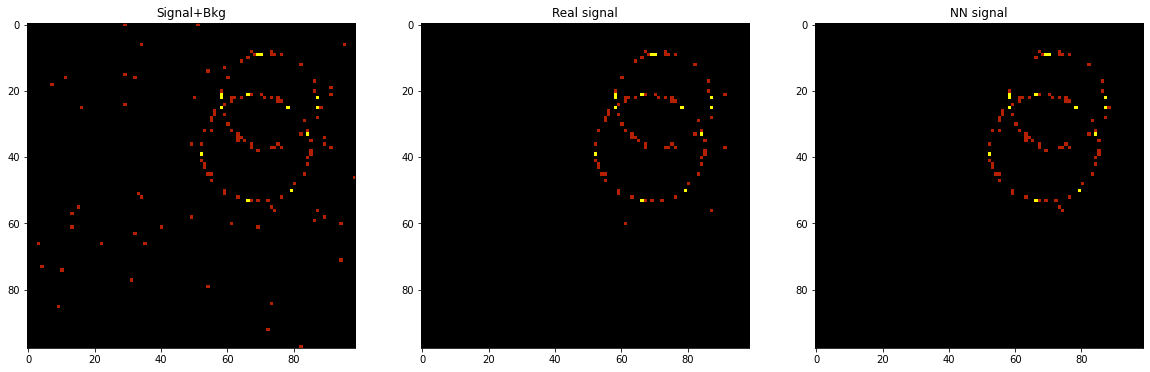

In [155]:
index+=1
plot(index)